# 导入相关库

In [1]:
import os
import numpy as np
# import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
# coding: UTF-8
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号#有中文出现的情况，需要u'内容'
import warnings
warnings.filterwarnings("ignore")

In [2]:
import itertools
import os
import sys

import matplotlib.pylab as plt
import numpy as np
import PIL.Image as Image
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.python.platform.build_info as build


print("Python version",sys.version)
print("numpy version",np.__version__)
print("pandas version",pd.__version__)
print("tensorflow GPU version",tf.__version__)
print("keras version",keras.__version__)

print("GPUs Available",len(tf.config.experimental.list_physical_devices('GPU')))
print("Cudnn version",build.build_info['cudnn_version'])
print("Cuda version",build.build_info['cuda_version'])

Python version 3.9.17 | packaged by conda-forge | (main, Aug 10 2023, 06:55:58) [MSC v.1929 64 bit (AMD64)]
numpy version 1.24.3
pandas version 2.0.3
tensorflow GPU version 2.10.1
keras version 2.10.0
GPUs Available 1
Cudnn version 64_8
Cuda version 64_112


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1


# 相关函数

## 读取数据dataframe（用于展示）

In [4]:
def DatadfGet(typeNum, SampleNum, path,features,min_max_scaler):
    # 读取数据
    datadf = pd.DataFrame()

    # for file_name in os.listdir(path):
    for i in range(typeNum):
        for j in range(1, SampleNum+1):  # 15个类别，每个类别取个SampleNum样本（1~SampleNum）
            df_temp = pd.read_csv(path + '\\' + 'data{0}_{1}.csv'.format(i, j), index_col=None, header=0)
            df_temp[features] = min_max_scaler.fit_transform(df_temp[features])
            datadf = pd.concat([datadf,df_temp])   
#             datadf.concat(df_temp)
    return datadf

In [5]:
def getId(SampleNum,typeNum,TimeStep):
# 获取机器id
    idLs=[]
    for i in range(SampleNum*typeNum):
        for j in range(TimeStep):
            idLs.append(i+1)
    return idLs

## 展示数据

In [6]:
def feature_show(datadf, total_title,selectId,features):
        # 将上面的图合并到一张图内
    raws = math.ceil(len(features)/2)
    fig,ax=plt.subplots(raws,2,figsize=(20,raws*1.2))  # 画布分为12行2列，面积为12*20
    fig.tight_layout()  # 自动调整子图参数以提供指定的填充，https://vimsky.com/examples/usage/matplotlib-figure-figure-tight_layout-in-python.html
#     fig.suptitle(total_title,y=1.04, fontsize=30)

    r,c,i=0,0,0
    for v_idx,v in enumerate(features):
        ax[r][c].plot('timestep',v,data=datadf[datadf['id']==selectId])       
        ax[r][c].set_title(features[i])
#         ax[r][c].set_xlabel('timestep')
#         ax[r][c].set_ylabel(v) 
        i = i+1
        if c<1:
            c+=1
        elif c==1:
            r+=1
            c-=1

In [7]:
def test_show(data,Id_ls,features):
        # 将上面的图合并到一张图内
    raws = math.ceil(len(features)/2)
#     fig,ax=plt.subplots(raws,2,figsize=(20,raws*1.2))  # 画布分为12行2列，面积为12*20
    fig,ax=plt.subplots(raws,2,figsize=(20,raws*1.2))
    fig.tight_layout()  # 自动调整子图参数以提供指定的填充，https://vimsky.com/examples/usage/matplotlib-figure-figure-tight_layout-in-python.html
#     fig.suptitle(total_title,y=1.03, fontsize=30)

    r,c,i=0,0,0
    for v_idx,v in enumerate(features):
        for id_num in range(len(Id_ls)):
            ax[r][c].plot('timestep',v,data=data[data['id']==Id_ls[id_num]])
        
#         ax[r][c].plot('timestep',v,data=data[data['id']==Id_ls[0]])
#         ax[r][c].plot('timestep',v,data=data[data['id']==Id_ls[1]])
#         ax[r][c].plot('timestep',v,data=data[data['id']==Id_ls[2]])
#         ax[r][c].plot('timestep',v,data=data[data['id']==Id_ls[3]])
#         ax[r][c].plot('timestep',v,data=data[data['id']==Id_ls[4]])
#         ax[r][c].plot('timestep',v,data=data[data['id']==Id_ls[5]])
#         ax[r][c].plot('timestep',v,data=test_datadf[test_datadf['id']==selectId]) 
        ax[r][c].set_title(features[i])
#         ax[r][c].set_xlabel('timestep')
#         ax[r][c].set_ylabel(v) 
        i = i+1
        if c<1:
            c+=1
        elif c==1:
             r+=1
             c-=1

## 读取实验数据

In [8]:
def DataGet(typeNum, SampleNum, path,features,min_max_scaler):
    # 读取数据
    data_ls = []
    datalabel_ls = []

    # for file_name in os.listdir(path):
    for i in range(typeNum):
        for j in range(1, SampleNum+1):  # 15个类别，每个类别取个SampleNum样本（1~SampleNum）
            df_temp = pd.read_csv(path + '\\' + 'data{0}_{1}.csv'.format(i, j), index_col=None, header=0)
            df_temp = df_temp[features+['SystemState']]
            df_temp[features] = min_max_scaler.fit_transform(df_temp[features])
            data_ls.append(df_temp.values[:, 0:-1])
            datalabel_ls.append(df_temp.values[0, -1])
    return data_ls,datalabel_ls

## 滑动窗口

In [9]:
def window(data_ls, datalabel_ls, window_size,step=1):
    # 滑动窗口
    data = []
    labels = []
    end = data_ls[0].shape[0]
    for id in range(len(data_ls)):
        start_index = 0
        end_index = start_index + window_size
        while(end_index <= end ):
            data.append(data_ls[id][start_index:end_index,:])
            labels.append(datalabel_ls[id])
            start_index = start_index+step
            end_index = end_index +step
    return np.array(data),np.array(labels)

# 相关算法

In [10]:
import tensorflow as tf
print("tensorflow version: {}". format(tf.__version__)) 
from tensorflow import keras
print("keras version: {}". format(keras.__version__)) 
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical,plot_model

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D,Dropout,Flatten,Dense,MaxPooling1D,BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.ensemble import RandomForestClassifier#随机森林

tensorflow version: 2.10.1
keras version: 2.10.0


## 绘制曲线

In [34]:
def plot_history(history, title):
    # 绘制loss曲线
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='训练损失')
    plt.plot(epochs, val_loss, 'r', label='验证损失')
    plt.title(title)
    plt.legend()
    plt.savefig(title,dpi=600, bbox_inches = 'tight')

    plt.show()    

## 混淆矩阵

In [35]:
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues,#这个地方设置混淆矩阵的颜色主题，这个主题看着就干净~
                          normalize=True,
                          picture_name='1.png'):
   
 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=35)
#     plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names,fontsize=30)
        plt.yticks(tick_marks, target_names, fontsize=30)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            if round(cm[i, j],2)!=0.00:
  
                plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black",fontsize=20)
        else:
      
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
#     for first_index in range(len(cm)):  # 第几行
#         for second_index in range(len(cm[first_index])):  # 第几列
#             temp = cm[first_index][second_index]
#             if temp == 0.0 or temp == 100.0:
#                 plt.text(first_index, second_index, int(temp), va='center',
#                          ha='center',
#                          fontsize=13.5)
#             else:
#                 plt.text(first_index, second_index, r'{0:.2f}'.format(temp), va='center',
#                          ha='center',
#                          fontsize=13.5)



    plt.tight_layout()
    plt.ylabel('真实值',fontsize=30)
    plt.xlabel('预测值',fontsize=30)
#     plt.xlabel('预测值\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass),fontsize=30)
    #这里这个savefig是保存图片，如果想把图存在什么地方就改一下下面的路径，然后dpi设一下分辨率即可。
    plt.savefig(picture_name,dpi=600, bbox_inches = 'tight')
    plt.show()
# 显示混淆矩阵
def plot_confuse(model, x_val, y_val,labels,batch,picture_name='1.png'):
    
    predict_x = model.predict(x_val,batch_size=batch)
    predictions = np.argmax(predict_x, axis=1)
    truelabel = y_val.argmax(axis=-1)   # 将one-hot转化为label
    print(truelabel )
    print(predictions)
    conf_mat = confusion_matrix(y_true=truelabel,y_pred=predictions)
    plt.figure()
    plot_confusion_matrix(conf_mat, normalize=True,target_names=labels,title='混淆矩阵',picture_name=picture_name)


## CNN

In [59]:
from sklearn import metrics 
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical,plot_model

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D,Dropout,Flatten,Dense,MaxPooling1D,BatchNormalization
from tensorflow.keras.optimizers import Adam

def CNN(x_train, y_train, x_test, y_test, EPOCHS, model_path,ifSaveModel=False):
#     x_train = np.array(x_train)
#     y_train = np.array(y_train)
#     x_test = np.array(x_test)
#     y_test = np.array(y_test)
    
    y_trains = to_categorical(y_train)
#     y_vals = to_categorical(y_val)
    y_tests = to_categorical(y_test)
#     x_train=np.transpose(x_train,(0,2,1))  # conv1D卷积在最后一维方向上 （样本数，特征数，序列步长）
#     x_test=np.transpose(x_test,(0,2,1))  # conv1D卷积在最后一维方向上 （样本数，特征数，序列步长）
#     print(x_train.shape)
    

    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu',
                                     input_shape=x_train[0].shape)) 
   
    model.add(BatchNormalization())
    model.add(MaxPooling1D())

    model.add(Conv1D(filters=64, kernel_size=2, activation='relu')) 
   
    model.add(BatchNormalization())
    model.add(MaxPooling1D())

    model.add(Flatten())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(15, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    print(model.summary())

    model_history = model.fit(x_train, y_trains, epochs=EPOCHS, batch_size=256,validation_split=0.25)

#     # 测试结果
    test_loss, test_acc = model.evaluate(x_test, y_tests)
    print('模型在测试集的诊断精度为：', test_acc)

    # 保存模型
    if ifSaveModel:
        model.save(model_path)  # HDF5文件，pip install h5py
    plot_history(model_history, 'CNN 训练和验证损失')

In [14]:
from sklearn import metrics 
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical,plot_model

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D,Dropout,Flatten,Dense,MaxPooling1D,BatchNormalization
from tensorflow.keras.optimizers import Adam

def CNN1(x_train, y_train, x_test, y_test, EPOCHS, model_path,ifSaveModel=False):
#     x_train = np.array(x_train)
#     y_train = np.array(y_train)
#     x_test = np.array(x_test)
#     y_test = np.array(y_test)
    
    y_trains = to_categorical(y_train)
#     y_vals = to_categorical(y_val)
    y_tests = to_categorical(y_test)
#     x_train=np.transpose(x_train,(0,2,1))  # conv1D卷积在最后一维方向上 （样本数，特征数，序列步长）
#     x_test=np.transpose(x_test,(0,2,1))  # conv1D卷积在最后一维方向上 （样本数，特征数，序列步长）
#     print(x_train.shape)
    

    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu',
                                     input_shape=x_train[0].shape)) 
   
    model.add(BatchNormalization())
    model.add(MaxPooling1D())

    model.add(Conv1D(filters=64, kernel_size=2, activation='relu')) 
   
    model.add(BatchNormalization())
    model.add(MaxPooling1D())

    model.add(Flatten())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(15, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    print(model.summary())

    model_history = model.fit(x_train, y_trains, epochs=EPOCHS, batch_size=256,validation_split=0.2)

#     # 测试结果
    test_loss, test_acc = model.evaluate(x_test, y_tests)
    print('模型在测试集的诊断精度为：', test_acc)

    # 保存模型
    if ifSaveModel:
        model.save(model_path)  # HDF5文件，pip install h5py
    plot_history(model_history, 'CNN 训练和验证损失')

## MLP

In [74]:
from sklearn import metrics 
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical,plot_model

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D,Dropout,Flatten,Dense,MaxPooling1D,BatchNormalization
from tensorflow.keras.optimizers import Adam

def MLP(x_train, y_train, x_test, y_test, EPOCHS, model_path,ifSaveModel=False):
#     x_train = np.array(x_train)
#     y_train = np.array(y_train)
#     x_test = np.array(x_test)
#     y_test = np.array(y_test)
    
    y_trains = to_categorical(y_train)
#     y_vals = to_categorical(y_val)
    y_tests = to_categorical(y_test)
#     x_train=np.transpose(x_train,(0,2,1))  # conv1D卷积在最后一维方向上 （样本数，特征数，序列步长）
#     x_test=np.transpose(x_test,(0,2,1))  # conv1D卷积在最后一维方向上 （样本数，特征数，序列步长）
#     print(x_train.shape)
    

    model = Sequential()


    model.add(Flatten())
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(15, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
#     print(model.summary())

    model_history = model.fit(x_train, y_trains, epochs=EPOCHS, batch_size=256,validation_split=0.25)

#     # 测试结果
    test_loss, test_acc = model.evaluate(x_test, y_tests)
    print('模型在测试集的诊断精度为：', test_acc)

    # 保存模型
    if ifSaveModel:
        model.save(model_path)  # HDF5文件，pip install h5py
    plot_history(model_history, 'MLP 训练和验证损失')

## 随机森林

In [15]:
# 随机森林
def Forest(x_train, y_train, x_test, y_test,features, n_es=100, ran_state =0):

    forest = RandomForestClassifier(n_estimators = n_es,random_state = ran_state)
    forest.fit(x_train,y_train)
    print("训练集精度为: {:.3f}".format((forest.score(x_train,y_train))))
    print("测试集精度为: {:.3f}".format((forest.score(x_test,y_test))))

    # 特征选择
    feature_names = np.array(features)
    can = {n: v for n, v in zip(feature_names, forest.feature_importances_)}
    plt.figure()
    plt.barh(list(can.keys()), list(can.values()), align='center')
    plt.xlabel("Feature Importances")
    plt.ylabel("Feature")
    plt.show()

## SVM

In [16]:
from sklearn import svm
from sklearn import metrics 
def svm_scv(x_train,y_train,x_test,y_test):
    classifier=svm.SVC(kernel='linear',gamma=0.1,decision_function_shape='ovo',C=0.1)
    classifier.fit(x_train,y_train.ravel())
    print("SVM-输出训练集的准确率为：",classifier.score(x_train,y_train))
    print("SVM-输出测试集的准确率为：",classifier.score(x_test,y_test))
    y_hat=classifier.predict(x_test)
    classreport=metrics.classification_report(y_test,y_hat)
    print(classreport)


## LGBM

In [17]:
## 导入LightGBM模型
from lightgbm import LGBMClassifier
from sklearn import metrics
import seaborn as sns

def lgbm(x_train,y_train,x_test,y_test):
    ## 定义 LightGBM 模型 
    clf = LGBMClassifier()
    # 在训练集上训练LightGBM模型
    clf.fit(x_train, y_train)
    ## 在训练集和测试集上分布利用训练好的模型进行预测
    train_predict = clf.predict(x_train)
    test_predict = clf.predict(x_test)

    ## 利用accuracy（准确度）【预测正确的样本数目占总预测样本数目的比例】评估模型效果
    print('The accuracy of the Logistic Regression is:',metrics.accuracy_score(y_train,train_predict))
    print('The accuracy of the Logistic Regression is:',metrics.accuracy_score(y_test,test_predict))

    ## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
    confusion_matrix_result = metrics.confusion_matrix(test_predict,y_test)
    print('The confusion matrix result:\n',confusion_matrix_result)

    # 利用热力图对于结果进行可视化
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

## NDTL-ＣＮＮ

In [86]:
def plot_history1(history, title):
    # 绘制loss曲线
    loss = history.history['loss']
#     val_loss = history.history['val_loss']

    epochs = range(len(loss))
    print(epochs)

    plt.figure()

    plt.plot(epochs, loss, 'b', label='训练损失')
#     plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.savefig(title,dpi=600, bbox_inches = 'tight')
    plt.savefig('NDTL-CNN训练损失.svg',format='svg',dpi=600)#输出

    plt.show()    

In [87]:
def TransLearning( model_path, x_test, y_test, a, EPOCHS):
    # 载入模型，查看模型信息
    model = models.load_model(model_path)
#     for (i, layer) in enumerate(model.layers):
#         print(i, layer)
#     print(model.summary())
#     plot_model(model,show_shapes="true")

    # 选择训练层
    # 选取原模型第一层至倒数第二层
    # model_trans = Model(inputs=model.input, outputs=model.layers[-4].output)
    model_trans = Sequential()
    for layer in model.layers[:-5]:  # 跳过最后一层
        model_trans.add(layer)
#     print(model_trans.summary())

    model_trans.add(Dense(64, activation='relu'))
#     model_trans.add(Dropout(0.25))
    model_trans.add(Dense(32, activation='relu'))
#     model_trans.add(Dropout(0.5))
    model_trans.add(Dense(15, activation='softmax'))
    model_trans.compile(optimizer=Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
#     print(model_trans.summary())

    # 加载数据
    x_test_train, x_test_test, y_test_train, y_test_test = train_test_split(x_test, y_test, test_size=1-a )
#     x_test_train = np.array(x_test_train)
#     y_test_train = np.array(y_test_train)
#     x_test_test = np.array(x_test_test)
#     y_test_test = np.array(y_test_test)
    
    y_test_trains = to_categorical(y_test_train)
    y_test_tests = to_categorical(y_test_test)

    model_history = model_trans.fit(x_test_train, y_test_trains, batch_size=256, epochs=EPOCHS)
    plot_history1(model_history, 'NDTL-CNN 训练损失')
    
    test_loss, test_acc = model.evaluate(x_test_test, y_test_tests, batch_size=256)
    print('未迁移学习后模型分类精度为：', test_acc)
    test_loss, test_acc = model_trans.evaluate(x_test_test, y_test_tests,batch_size=256)
    print('迁移学习后模型分类精度为：', test_acc)
    
    model_trans.save('trans_model.h5')  # HDF5文件，pip install h5py

In [76]:
def TransLearning1( model_path, x_test, y_test, a, EPOCHS):
    # 载入模型，查看模型信息
    model = models.load_model(model_path)
#     for (i, layer) in enumerate(model.layers):
#         print(i, layer)
#     print(model.summary())
#     plot_model(model,show_shapes="true")

    # 选择训练层
    # 选取原模型第一层至倒数第二层
    # model_trans = Model(inputs=model.input, outputs=model.layers[-4].output)
    model_trans = Sequential()
    for layer in model.layers[:-5]:  # 跳过最后一层
        model_trans.add(layer)
#     print(model_trans.summary())

    model_trans.add(Dense(64, activation='relu'))
#     model_trans.add(Dropout(0.25))
    model_trans.add(Dense(32, activation='relu'))
#     model_trans.add(Dropout(0.5))
    model_trans.add(Dense(15, activation='softmax'))
    model_trans.compile(optimizer=Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
#     print(model_trans.summary())

    # 加载数据
    x_test_train, x_test_test, y_test_train, y_test_test = train_test_split(x_test, y_test, test_size=1-a )
#     x_test_train = np.array(x_test_train)
#     y_test_train = np.array(y_test_train)
#     x_test_test = np.array(x_test_test)
#     y_test_test = np.array(y_test_test)
    
    y_test_trains = to_categorical(y_test_train)
    y_test_tests = to_categorical(y_test_test)

    model_history = model_trans.fit(x_test_train, y_test_trains, batch_size=256, epochs=EPOCHS)
    plot_history1(model_history, 'NDTL-MLP 训练损失')
    
    test_loss, test_acc = model.evaluate(x_test_test, y_test_tests, batch_size=256)
    print('未迁移学习后模型分类精度为：', test_acc)
    test_loss, test_acc = model_trans.evaluate(x_test_test, y_test_tests,batch_size=256)
    print('迁移学习后模型分类精度为：', test_acc)
    
    model_trans.save('trans_model1.h5')  # HDF5文件，pip install h5py

# 参数设置

In [39]:
StartTime = 0.0  # 仿真开始时间 0s
FinalTime = 3.0  # 仿真结束时间 3.0s
train_SampleNum = 100 #每个类别100个样本

train_val_SampleNum = 80  # 每个类别100个样本
test_SampleNum = 20  # 每个类别15个样本
typeNum = 15  # 类别数
TimeStep = int(FinalTime / 0.001) + 1
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))  # 归一化范围为-1~1
train_path = '.\\Data\\TrainData_highAcc'
test_path = '.\\Data\\TestData_highAcc'

features = ['phi', 'w', 'motorsystem_n_motor', 'motorsystem_tau_shaft', 'motorsystem_tau_electrical',
           'motorsystem_i1', 'motorsystem_i2', 'motorsystem_i3', 'mechanicssystem_flange_a_phi',
           'mechanicssystem_flange_a_tau', 'mechanicssystem_flange_r_phi',
           'mechanicssystem_flange_r_tau',
           'structuresystem_flange_a_phi', 'structuresystem_flange_a_tau',
           'structuresystem_flange_b_phi',
           'structuresystem_flange_b_tau', 'controlsystem_angle'] # 17

part_features = [ 'motorsystem_i1', 'motorsystem_i2', 'motorsystem_i3','motorsystem_n_motor', 'motorsystem_tau_shaft',
           'phi', 'w','mechanicssystem_flange_r_tau'] # 选取8个主要特征
columns =['timestep']+ features + ['systemstate'] # 19

label_name = ['无故障','电机电枢电阻短路','电机电枢电阻断路','电机转轴卡死','电机性能下降','控制器放大器恒增益',
             '控制器放大器恒偏差','控制器放大器失效','角度传感器恒增益','角度传感器恒偏差','角度传感器失效','速度传感器恒增益','速度传感器恒偏差',
             '速度传感器失效','齿轮效率下降']  # 标签名称

#-----------------------------------------------------------------------------------------------------------------------------

# 数据构建相关
window_size = 300  # 滑动窗口大小
window_step = 10  # 滑动窗口步长 

batch_size = 256

#------------------------------------------------------------------------------------------------------------------------------------

# 模型选定义及训练相关

EPOCHS =200 # epoch为200
ifSaveModel =True # 是否保存模型
a = 0.3  # 迁移学习训练集比例


# 实验操作

## 定工况

In [40]:
# 读取数据集
data_ls, label_ls = DataGet(typeNum, train_SampleNum, train_path, part_features,min_max_scaler)
len(data_ls)

1500

In [41]:
# 滑动窗口处理，获得数组
window_size = 300
window_step=10
# 滑动窗口
data_window,label_window = window(data_ls, label_ls , window_size =window_size ,step=window_step)  # 大小为300，步长为10
len(data_window)

406500

In [42]:
index = [i for i in range(len(data_window))]
np.random.shuffle(index)
data_window = data_window[index]
label_window = label_window[index]

In [43]:
from sklearn.model_selection import train_test_split
# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(data_window,label_window, test_size = 0.2)

In [44]:
print(x_train.shape,x_test.shape)

(325200, 300, 8) (81300, 300, 8)


In [45]:
print(type(x_train))

<class 'numpy.ndarray'>


### CNN

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 299, 32)           544       
                                                                 
 batch_normalization_12 (Bat  (None, 299, 32)          128       
 chNormalization)                                                
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 149, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 148, 64)           4160      
                                                                 
 batch_normalization_13 (Bat  (None, 148, 64)          256       
 chNormalization)                                                
                                                      

953/953 [==============================] - 10s 11ms/step - loss: 0.1930 - accuracy: 0.9080 - val_loss: 0.1767 - val_accuracy: 0.9106
Epoch 98/200
953/953 [==============================] - 11s 11ms/step - loss: 0.1922 - accuracy: 0.9093 - val_loss: 0.1768 - val_accuracy: 0.9120
Epoch 99/200
953/953 [==============================] - 11s 11ms/step - loss: 0.1903 - accuracy: 0.9094 - val_loss: 0.1763 - val_accuracy: 0.9100
Epoch 100/200
953/953 [==============================] - 11s 11ms/step - loss: 0.1901 - accuracy: 0.9098 - val_loss: 0.1806 - val_accuracy: 0.9094
Epoch 101/200
953/953 [==============================] - 10s 11ms/step - loss: 0.1903 - accuracy: 0.9096 - val_loss: 0.1790 - val_accuracy: 0.9102
Epoch 102/200
953/953 [==============================] - 11s 11ms/step - loss: 0.1899 - accuracy: 0.9099 - val_loss: 0.1795 - val_accuracy: 0.9101
Epoch 103/200
953/953 [==============================] - 11s 11ms/step - loss: 0.1893 - accuracy: 0.9109 - val_loss: 0.1832 - val_accu

Epoch 153/200
953/953 [==============================] - 11s 11ms/step - loss: 0.1679 - accuracy: 0.9230 - val_loss: 0.1783 - val_accuracy: 0.9170
Epoch 154/200
953/953 [==============================] - 11s 11ms/step - loss: 0.1670 - accuracy: 0.9236 - val_loss: 0.1747 - val_accuracy: 0.9151
Epoch 155/200
953/953 [==============================] - 11s 11ms/step - loss: 0.1689 - accuracy: 0.9230 - val_loss: 0.1728 - val_accuracy: 0.9167
Epoch 156/200
953/953 [==============================] - 11s 11ms/step - loss: 0.1666 - accuracy: 0.9235 - val_loss: 0.1829 - val_accuracy: 0.9148
Epoch 157/200
953/953 [==============================] - 11s 11ms/step - loss: 0.1660 - accuracy: 0.9239 - val_loss: 0.1712 - val_accuracy: 0.9174
Epoch 158/200
953/953 [==============================] - 11s 11ms/step - loss: 0.1669 - accuracy: 0.9241 - val_loss: 0.1750 - val_accuracy: 0.9154
Epoch 159/200
953/953 [==============================] - 11s 11ms/step - loss: 0.1662 - accuracy: 0.9240 - val_loss: 0

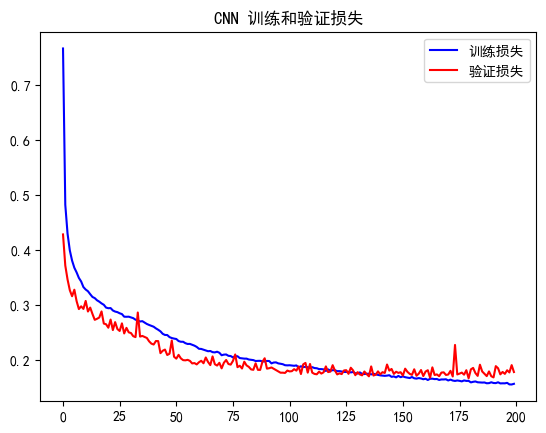

In [60]:
model_path = 'CNN.h5'
CNN(x_train, y_train, x_test, y_test,EPOCHS, model_path,ifSaveModel=True)

318/318 [==============================] - 1s 2ms/step
[6 4 2 ... 9 9 9]
[6 4 2 ... 9 9 9]


<Figure size 640x480 with 0 Axes>

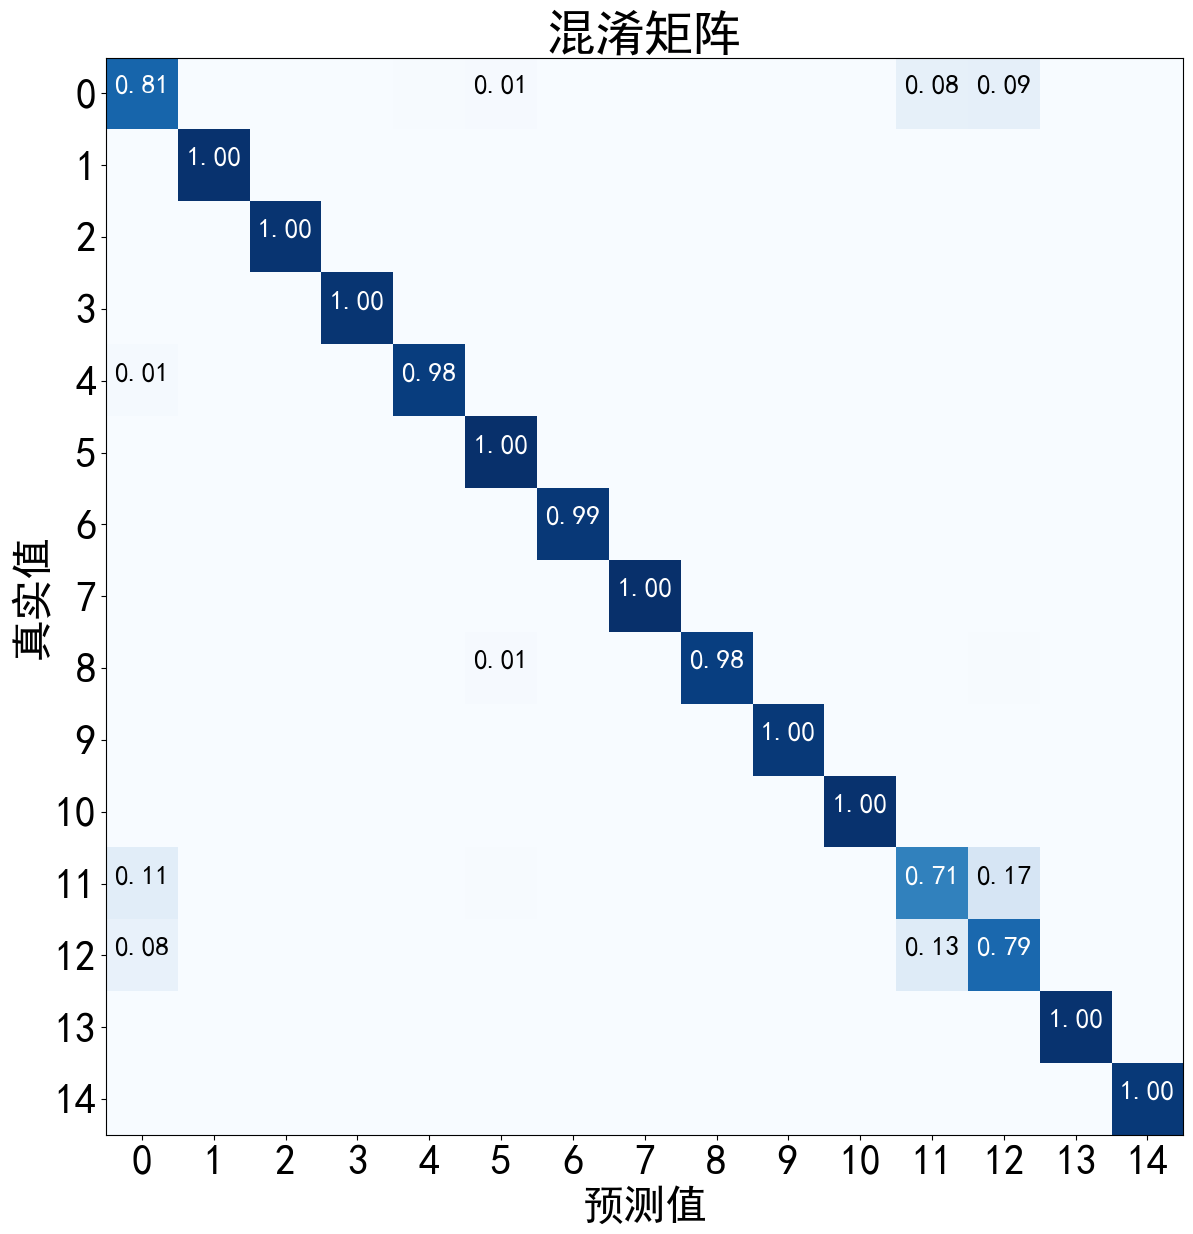

In [47]:
labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
CNN_model = models.load_model(model_path)
# x_test_train, x_test_test, y_test_train, y_test_test = train_test_split(x_test, y_test, test_size=a )

y_test = np.array(y_test)
y_tests = to_categorical(y_test)

plot_confuse(CNN_model,x_test,y_tests,labels,256,"图8.png")

## 变工况

In [48]:
# 读取数据集
train_val_data_ls, train_val_label_ls = DataGet(typeNum, train_val_SampleNum, train_path, part_features,min_max_scaler)
test_data_ls, test_label_ls = DataGet(typeNum, test_SampleNum, test_path, part_features,min_max_scaler)
print(len(train_val_data_ls),len(test_data_ls))

1200 300


In [49]:
# 滑动窗口处理，获得数组
window_size = 300
window_step=10
# 滑动窗口
x_train1,y_train1 = window(train_val_data_ls, train_val_label_ls , window_size =window_size ,step=window_step)  # 大小为300，步长为10
x_test1,y_test1 = window(test_data_ls, test_label_ls , window_size =window_size ,step=window_step)  # 大小为300，步长为10

index = [i for i in range(len(x_train1))]
np.random.shuffle(index)
x_train1 = x_train1[index]
y_train1 = y_train1[index]

index = [i for i in range(len(x_test1))]
np.random.shuffle(index)
x_test1 = x_test1[index]
y_test1 = y_test1[index]


x_train1 = np.array(x_train1)
y_train1 = np.array(y_train1)
x_test1 = np.array(x_test1)
y_test1 = np.array(y_test1)

print(x_train1.shape,x_test1.shape)


(325200, 300, 8) (81300, 300, 8)


### CNN

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 299, 32)           544       
                                                                 
 batch_normalization_6 (Batc  (None, 299, 32)          128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 149, 32)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 148, 64)           4160      
                                                                 
 batch_normalization_7 (Batc  (None, 148, 64)          256       
 hNormalization)                                                 
                                                      

1017/1017 [==============================] - 11s 11ms/step - loss: 0.0860 - accuracy: 0.9658 - val_loss: 0.0966 - val_accuracy: 0.9616
Epoch 42/200
1017/1017 [==============================] - 11s 11ms/step - loss: 0.0863 - accuracy: 0.9658 - val_loss: 0.1157 - val_accuracy: 0.9543
Epoch 43/200
1017/1017 [==============================] - 11s 11ms/step - loss: 0.0827 - accuracy: 0.9676 - val_loss: 0.1076 - val_accuracy: 0.9567
Epoch 44/200
1017/1017 [==============================] - 11s 11ms/step - loss: 0.0829 - accuracy: 0.9680 - val_loss: 0.0991 - val_accuracy: 0.9616
Epoch 45/200
1017/1017 [==============================] - 11s 11ms/step - loss: 0.0802 - accuracy: 0.9693 - val_loss: 0.0954 - val_accuracy: 0.9621
Epoch 46/200
1017/1017 [==============================] - 11s 11ms/step - loss: 0.0788 - accuracy: 0.9693 - val_loss: 0.0993 - val_accuracy: 0.9609
Epoch 47/200
1017/1017 [==============================] - 11s 11ms/step - loss: 0.0765 - accuracy: 0.9702 - val_loss: 0.0925 

1017/1017 [==============================] - 11s 11ms/step - loss: 0.0303 - accuracy: 0.9898 - val_loss: 0.1217 - val_accuracy: 0.9639
Epoch 152/200
1017/1017 [==============================] - 11s 11ms/step - loss: 0.0343 - accuracy: 0.9891 - val_loss: 0.1079 - val_accuracy: 0.9682
Epoch 153/200
1017/1017 [==============================] - 11s 11ms/step - loss: 0.0311 - accuracy: 0.9895 - val_loss: 0.0997 - val_accuracy: 0.9696
Epoch 154/200
1017/1017 [==============================] - 11s 11ms/step - loss: 0.0297 - accuracy: 0.9899 - val_loss: 0.1098 - val_accuracy: 0.9667
Epoch 155/200
1017/1017 [==============================] - 11s 11ms/step - loss: 0.0316 - accuracy: 0.9896 - val_loss: 0.1156 - val_accuracy: 0.9662
Epoch 156/200
1017/1017 [==============================] - 11s 11ms/step - loss: 0.0332 - accuracy: 0.9890 - val_loss: 0.1004 - val_accuracy: 0.9683
Epoch 157/200
1017/1017 [==============================] - 11s 11ms/step - loss: 0.0302 - accuracy: 0.9899 - val_loss: 0

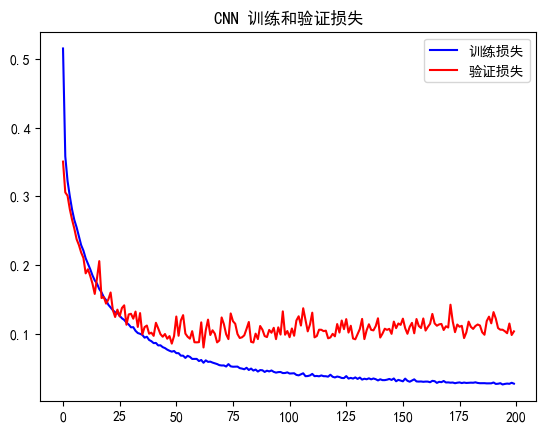

In [50]:
model_path = 'CNN1.h5'
CNN1(x_train1, y_train1,x_test1, y_test1, EPOCHS, model_path,ifSaveModel=True)

318/318 [==============================] - 1s 2ms/step
[ 0  0  0 ... 14 14 14]
[11 11 11 ... 14 14 14]


<Figure size 640x480 with 0 Axes>

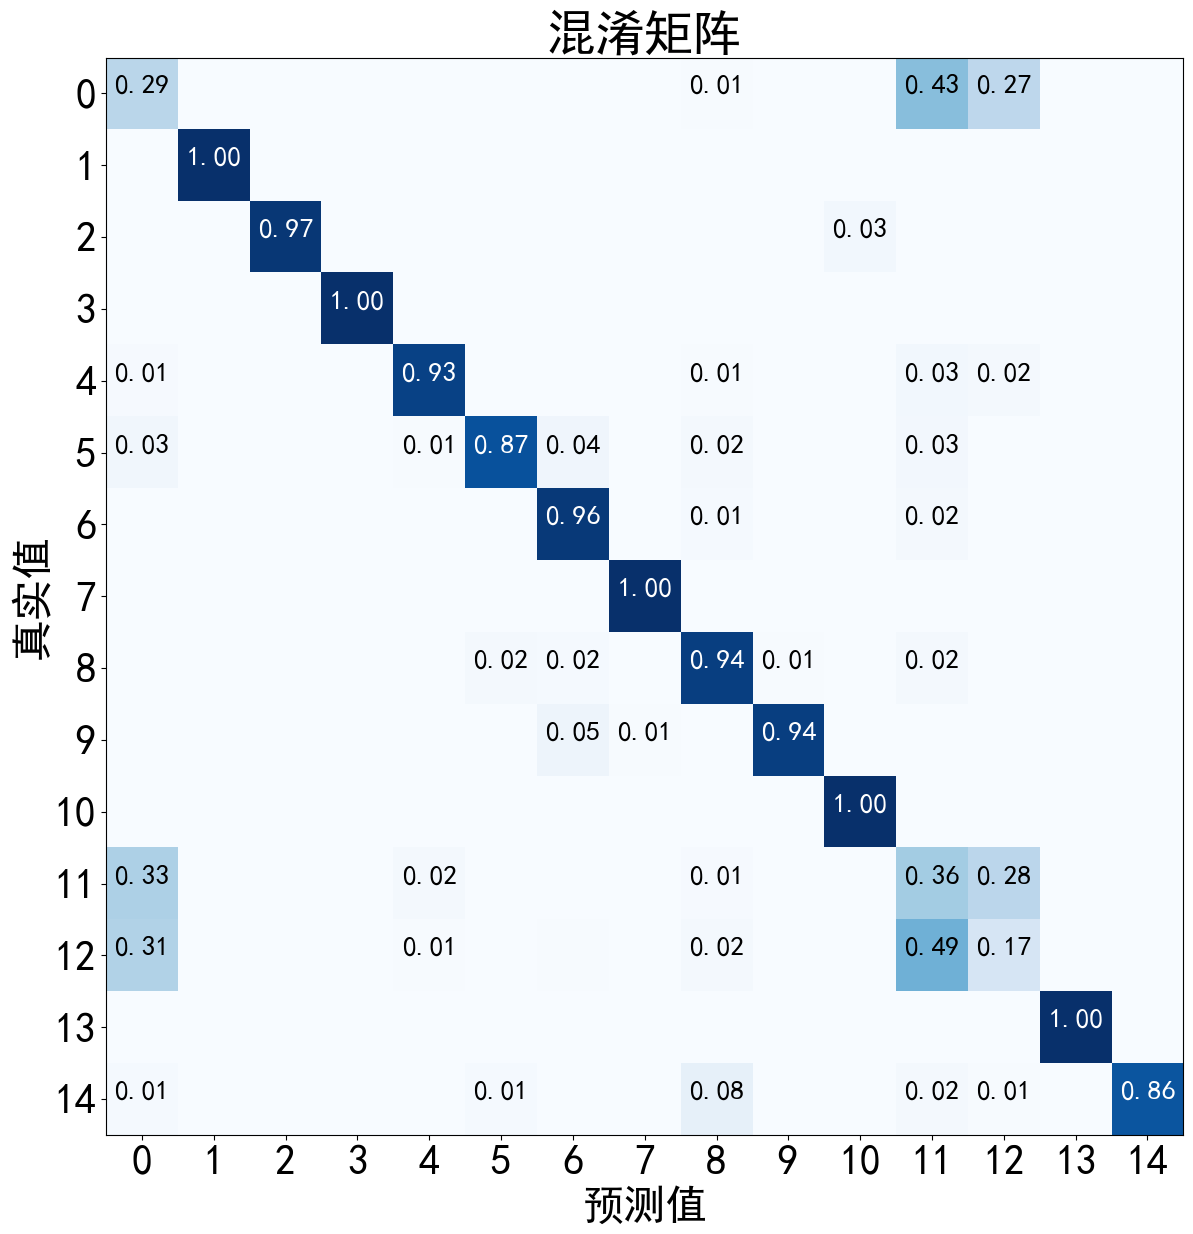

In [32]:
labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
CNN_model1 = models.load_model(model_path)
# x_test_train, x_test_test, y_test_train, y_test_test = train_test_split(x_test, y_test, test_size=a )


y_test1 = np.array(y_test1)
y_tests1 = to_categorical(y_test1)

plot_confuse(CNN_model1,x_test1,y_tests1,labels,256,"图12(a).png")

### NDTL-CNN

Epoch 1/5
96/96 [==============================] - 2s 12ms/step - loss: 0.5232 - accuracy: 0.8233
Epoch 2/5
96/96 [==============================] - 1s 13ms/step - loss: 0.1283 - accuracy: 0.9535
Epoch 3/5
96/96 [==============================] - 1s 14ms/step - loss: 0.0601 - accuracy: 0.9822
Epoch 4/5
96/96 [==============================] - 1s 14ms/step - loss: 0.0270 - accuracy: 0.9938
Epoch 5/5
96/96 [==============================] - 1s 12ms/step - loss: 0.0121 - accuracy: 0.9982
range(0, 5)


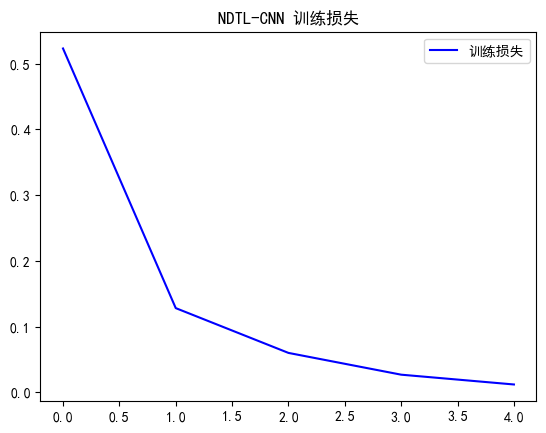

223/223 [==============================] - 1s 3ms/step - loss: 2.9698 - accuracy: 0.8158
未迁移学习后模型分类精度为： 0.8158496022224426
223/223 [==============================] - 1s 3ms/step - loss: 0.0682 - accuracy: 0.9756
迁移学习后模型分类精度为： 0.9755579233169556


In [89]:
a=0.3
model_path = 'CNN1.h5'
TransLearning( model_path, x_test1, y_test1, a, 5)

318/318 [==============================] - 1s 3ms/step
[ 5 10  6 ... 10  3  7]
[ 5 10  6 ... 10  3  7]


<Figure size 640x480 with 0 Axes>

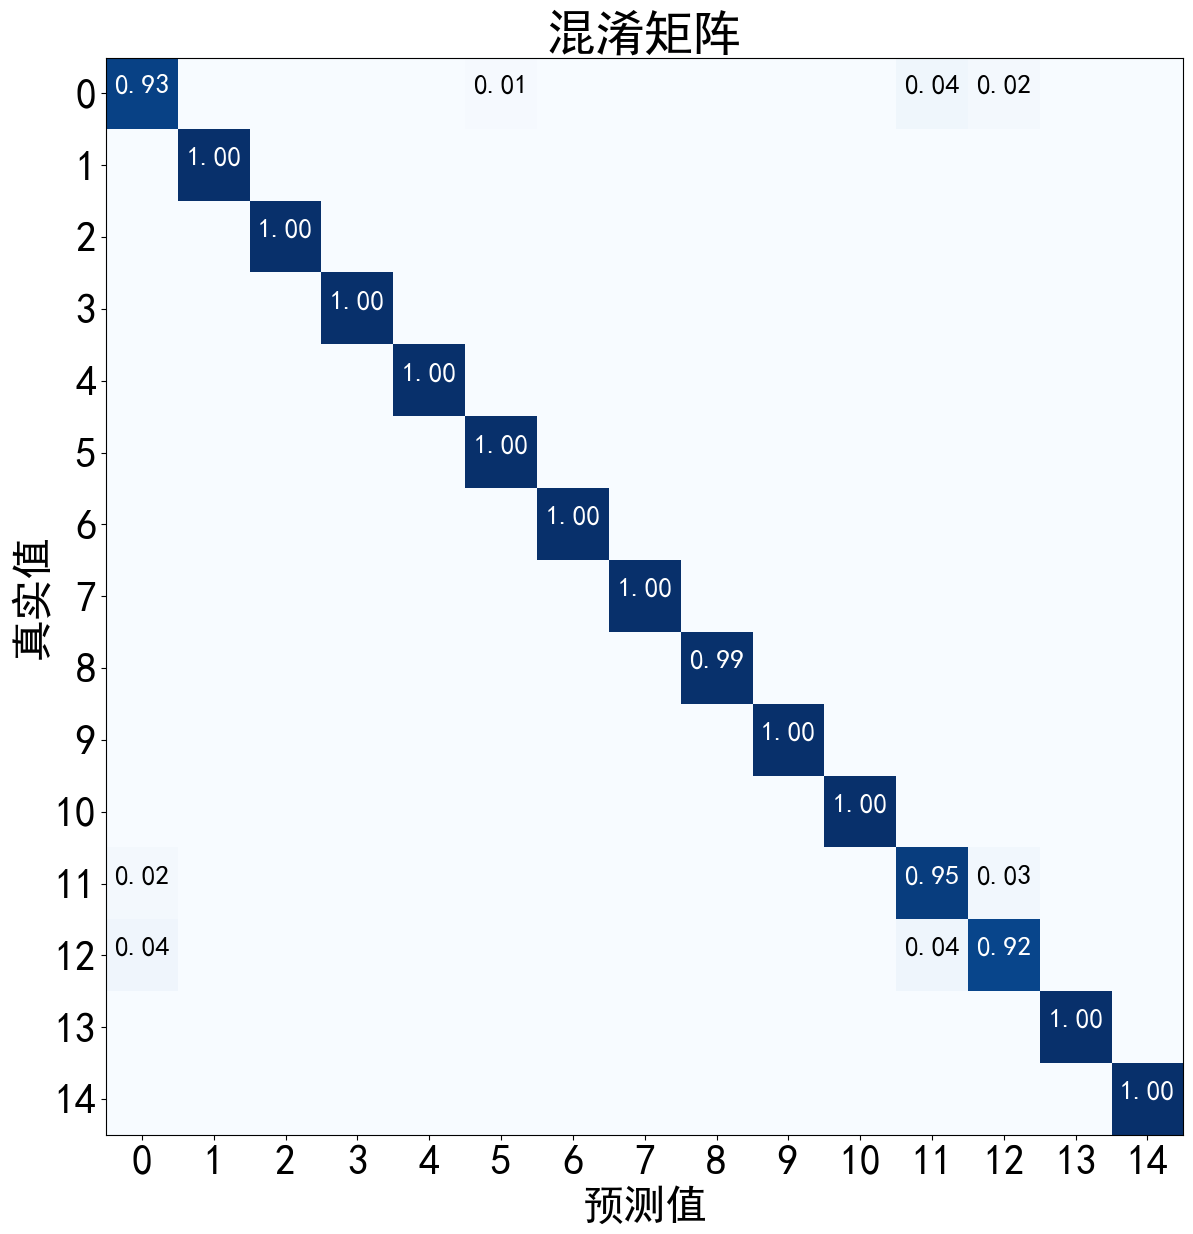

In [52]:
labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
model_path = 'trans_model.h5'
NDTL_CNN_model = models.load_model(model_path)
# x_test_train, x_test_test, y_test_train, y_test_test = train_test_split(x_test, y_test, test_size=a )

y_test1 = np.array(y_test1)
y_tests1 = to_categorical(y_test1)
plot_confuse(NDTL_CNN_model,x_test1,y_tests1,labels,256,"图12(b).png")

### MLP

Epoch 1/200
953/953 [==============================] - 11s 11ms/step - loss: 0.8801 - accuracy: 0.6764 - val_loss: 0.4975 - val_accuracy: 0.7867
Epoch 2/200
953/953 [==============================] - 9s 10ms/step - loss: 0.5140 - accuracy: 0.7845 - val_loss: 0.4270 - val_accuracy: 0.8120
Epoch 3/200
953/953 [==============================] - 9s 10ms/step - loss: 0.4598 - accuracy: 0.8030 - val_loss: 0.3874 - val_accuracy: 0.8285
Epoch 4/200
953/953 [==============================] - 9s 10ms/step - loss: 0.4322 - accuracy: 0.8118 - val_loss: 0.3647 - val_accuracy: 0.8286
Epoch 5/200
953/953 [==============================] - 9s 10ms/step - loss: 0.4178 - accuracy: 0.8178 - val_loss: 0.3957 - val_accuracy: 0.8256
Epoch 6/200
953/953 [==============================] - 9s 10ms/step - loss: 0.4060 - accuracy: 0.8218 - val_loss: 0.3881 - val_accuracy: 0.8235
Epoch 7/200
953/953 [==============================] - 9s 10ms/step - loss: 0.3986 - accuracy: 0.8246 - val_loss: 0.4679 - val_accuracy

953/953 [==============================] - 9s 10ms/step - loss: 0.2145 - accuracy: 0.9078 - val_loss: 0.1598 - val_accuracy: 0.9369
Epoch 114/200
953/953 [==============================] - 9s 10ms/step - loss: 0.2095 - accuracy: 0.9096 - val_loss: 0.1542 - val_accuracy: 0.9392
Epoch 115/200
953/953 [==============================] - 9s 10ms/step - loss: 0.2112 - accuracy: 0.9100 - val_loss: 0.1437 - val_accuracy: 0.9452
Epoch 116/200
953/953 [==============================] - 9s 10ms/step - loss: 0.2092 - accuracy: 0.9100 - val_loss: 0.1460 - val_accuracy: 0.9459
Epoch 117/200
953/953 [==============================] - 9s 10ms/step - loss: 0.2096 - accuracy: 0.9102 - val_loss: 0.1501 - val_accuracy: 0.9387
Epoch 118/200
953/953 [==============================] - 9s 10ms/step - loss: 0.2089 - accuracy: 0.9105 - val_loss: 0.1444 - val_accuracy: 0.9442
Epoch 119/200
953/953 [==============================] - 9s 10ms/step - loss: 0.2058 - accuracy: 0.9114 - val_loss: 0.1436 - val_accuracy:

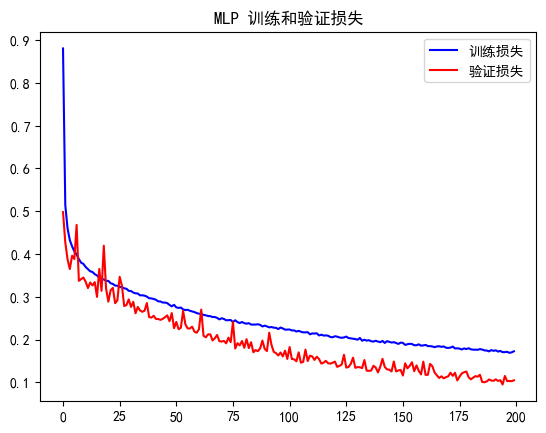

In [75]:
model_path = 'MLP.h5'
MLP(x_train1, y_train1,x_test1, y_test1, EPOCHS, model_path,ifSaveModel=True)

### NDTL-MLP

Epoch 1/5
96/96 [==============================] - 1s 8ms/step - loss: 1.2776 - accuracy: 0.6444
Epoch 2/5
96/96 [==============================] - 1s 8ms/step - loss: 0.3468 - accuracy: 0.8642
Epoch 3/5
96/96 [==============================] - 1s 8ms/step - loss: 0.2301 - accuracy: 0.9125
Epoch 4/5
96/96 [==============================] - 1s 8ms/step - loss: 0.1727 - accuracy: 0.9402
Epoch 5/5
96/96 [==============================] - 1s 8ms/step - loss: 0.1300 - accuracy: 0.9554


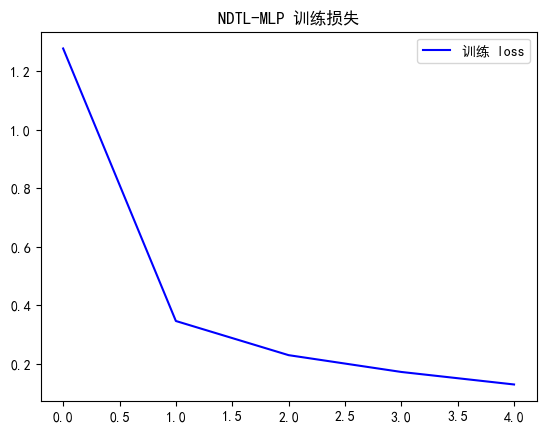

223/223 [==============================] - 1s 4ms/step - loss: 1.7473 - accuracy: 0.8153
未迁移学习后模型分类精度为： 0.8152521252632141
223/223 [==============================] - 1s 3ms/step - loss: 0.1565 - accuracy: 0.9419
迁移学习后模型分类精度为： 0.9419082999229431


In [78]:
a=0.3
model_path = 'MLP.h5'
TransLearning1( model_path, x_test1, y_test1, a, 5)

In [ ]:
def TransLearning( model_path, x_test, y_test, a, EPOCHS):
    # 载入模型，查看模型信息
    model = models.load_model(model_path)
#     for (i, layer) in enumerate(model.layers):
#         print(i, layer)
#     print(model.summary())
#     plot_model(model,show_shapes="true")

    # 选择训练层
    # 选取原模型第一层至倒数第二层
    # model_trans = Model(inputs=model.input, outputs=model.layers[-4].output)
    model_trans = Sequential()
    for layer in model.layers[:-5]:  # 跳过最后一层
        model_trans.add(layer)
#     print(model_trans.summary())

    model_trans.add(Dense(64, activation='relu'))
#     model_trans.add(Dropout(0.25))
    model_trans.add(Dense(32, activation='relu'))
#     model_trans.add(Dropout(0.5))
    model_trans.add(Dense(15, activation='softmax'))
    model_trans.compile(optimizer=Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
#     print(model_trans.summary())

    # 加载数据
    x_test_train, x_test_test, y_test_train, y_test_test = train_test_split(x_test, y_test, test_size=1-a )
#     x_test_train = np.array(x_test_train)
#     y_test_train = np.array(y_test_train)
#     x_test_test = np.array(x_test_test)
#     y_test_test = np.array(y_test_test)
    
    y_test_trains = to_categorical(y_test_train)
    y_test_tests = to_categorical(y_test_test)

    model_history = model_trans.fit(x_test_train, y_test_trains, batch_size=256, epochs=EPOCHS)
#     plot_history1(model_history, 'NDTL-CNN 训练损失')
    
    test_loss, test_acc = model.evaluate(x_test_test, y_test_tests, batch_size=256)
    print('未迁移学习后模型分类精度为：', test_acc)
    test_loss, test_acc = model_trans.evaluate(x_test_test, y_test_tests,batch_size=256)
    print('迁移学习后模型分类精度为：', test_acc)
    
#     model_trans.save('trans_model.h5')  # HDF5文件，pip install h5py

In [91]:
model_path = 'CNN1.h5'
model = models.load_model(model_path)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 299, 32)           544       
                                                                 
 batch_normalization_6 (Batc  (None, 299, 32)          128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 149, 32)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 148, 64)           4160      
                                                                 
 batch_normalization_7 (Batc  (None, 148, 64)          256       
 hNormalization)                                                 
                                                      

## 调整分类层

In [92]:
def TransLearning_1( model_path, x_test, y_test, a, EPOCHS):
    # 载入模型，查看模型信息
    model = models.load_model(model_path)
#     for (i, layer) in enumerate(model.layers):
#         print(i, layer)
#     print(model.summary())
#     plot_model(model,show_shapes="true")

    # 选择训练层
    # 选取原模型第一层至倒数第二层
    # model_trans = Model(inputs=model.input, outputs=model.layers[-4].output)
    model_trans = Sequential()
    for layer in model.layers[:-1]:  # 跳过最后一层
        model_trans.add(layer)
#     print(model_trans.summary())

#     model_trans.add(Dense(64, activation='relu'))
# #     model_trans.add(Dropout(0.25))
#     model_trans.add(Dense(32, activation='relu'))
#     model_trans.add(Dropout(0.5))
    model_trans.add(Dense(15, activation='softmax'))
    model_trans.compile(optimizer=Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
#     print(model_trans.summary())

    # 加载数据
    x_test_train, x_test_test, y_test_train, y_test_test = train_test_split(x_test, y_test, test_size=1-a )
#     x_test_train = np.array(x_test_train)
#     y_test_train = np.array(y_test_train)
#     x_test_test = np.array(x_test_test)
#     y_test_test = np.array(y_test_test)
    
    y_test_trains = to_categorical(y_test_train)
    y_test_tests = to_categorical(y_test_test)

    model_history = model_trans.fit(x_test_train, y_test_trains, batch_size=256, epochs=EPOCHS)
#     plot_history1(model_history, 'NDTL-CNN 训练损失')
    
    test_loss, test_acc = model.evaluate(x_test_test, y_test_tests, batch_size=256)
    print('未迁移学习后模型分类精度为：', test_acc)
    test_loss, test_acc = model_trans.evaluate(x_test_test, y_test_tests,batch_size=256)
    print('迁移学习后模型分类精度为：', test_acc)
    
#     model_trans.save('trans_model.h5')  # HDF5文件，pip install h5py

In [93]:
a=0.3
model_path = 'CNN1.h5'
TransLearning_1( model_path, x_test1, y_test1, a, 5)

Epoch 1/5
96/96 [==============================] - 2s 15ms/step - loss: 10.7460 - accuracy: 0.3572
Epoch 2/5
96/96 [==============================] - 1s 12ms/step - loss: 1.5422 - accuracy: 0.5883
Epoch 3/5
96/96 [==============================] - 1s 13ms/step - loss: 0.9378 - accuracy: 0.7223
Epoch 4/5
96/96 [==============================] - 1s 13ms/step - loss: 0.6762 - accuracy: 0.7829
Epoch 5/5
223/223 [==============================] - 1s 3ms/step - loss: 4.9758 - accuracy: 0.5221
未迁移学习后模型分类精度为： 0.5221050977706909
223/223 [==============================] - 1s 3ms/step - loss: 0.3091 - accuracy: 0.8719
迁移学习后模型分类精度为： 0.8719205856323242


## 调整Dense1

In [120]:
def TransLearning_2( model_path, x_test, y_test, a, EPOCHS):
    # 载入模型，查看模型信息
    model = models.load_model(model_path)
#     for (i, layer) in enumerate(model.layers):
#         print(i, layer)
#     print(model.summary())
#     plot_model(model,show_shapes="true")

    # 选择训练层
    # 选取原模型第一层至倒数第二层
    # model_trans = Model(inputs=model.input, outputs=model.layers[-4].output)
    model_trans = Sequential()
    for layer in model.layers[:-5]:  # 跳过最后一层
        model_trans.add(layer)
#     print(model_trans.summary())

    model_trans.add(Dense(64, activation='relu'))
    for layer in model.layers[-4:-1]:  # 跳过最后一层
        model_trans.add(layer)
    model_trans.add( model.layers[-1])
    

    model_trans.compile(optimizer=Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model_trans.summary())

    # 加载数据
    x_test_train, x_test_test, y_test_train, y_test_test = train_test_split(x_test, y_test, test_size=1-a )
#     x_test_train = np.array(x_test_train)
#     y_test_train = np.array(y_test_train)
#     x_test_test = np.array(x_test_test)
#     y_test_test = np.array(y_test_test)
    
    y_test_trains = to_categorical(y_test_train)
    y_test_tests = to_categorical(y_test_test)

    model_history = model_trans.fit(x_test_train, y_test_trains, batch_size=256, epochs=EPOCHS)
#     plot_history1(model_history, 'NDTL-CNN 训练损失')
    
    test_loss, test_acc = model.evaluate(x_test_test, y_test_tests, batch_size=256)
    print('未迁移学习后模型分类精度为：', test_acc)
    test_loss, test_acc = model_trans.evaluate(x_test_test, y_test_tests,batch_size=256)
    print('迁移学习后模型分类精度为：', test_acc)
    
#     model_trans.save('trans_model.h5')  # HDF5文件，pip install h5py

In [121]:
a=0.3
model_path = 'CNN1.h5'
TransLearning_2( model_path, x_test1, y_test1, a, 5)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 299, 32)           544       
                                                                 
 batch_normalization_6 (Batc  (None, 299, 32)          128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 149, 32)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 148, 64)           4160      
                                                                 
 batch_normalization_7 (Batc  (None, 148, 64)          256       
 hNormalization)                                                 
                                                     

## 调整Dense2

In [106]:
def TransLearning_3( model_path, x_test, y_test, a, EPOCHS):
    # 载入模型，查看模型信息
    model = models.load_model(model_path)
#     for (i, layer) in enumerate(model.layers):
#         print(i, layer)
#     print(model.summary())
#     plot_model(model,show_shapes="true")

    # 选择训练层
    # 选取原模型第一层至倒数第二层
    # model_trans = Model(inputs=model.input, outputs=model.layers[-4].output)
    model_trans = Sequential()
    for layer in model.layers[:-3]:  # 跳过最后一层
        model_trans.add(layer)
#     print(model_trans.summary())

    model_trans.add(Dense(32, activation='relu'))
    model_trans.add( model.layers[-2])
    
    model_trans.add( model.layers[-1])
    

    model_trans.compile(optimizer=Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model_trans.summary())

    # 加载数据
    x_test_train, x_test_test, y_test_train, y_test_test = train_test_split(x_test, y_test, test_size=1-a )
#     x_test_train = np.array(x_test_train)
#     y_test_train = np.array(y_test_train)
#     x_test_test = np.array(x_test_test)
#     y_test_test = np.array(y_test_test)
    
    y_test_trains = to_categorical(y_test_train)
    y_test_tests = to_categorical(y_test_test)

    model_history = model_trans.fit(x_test_train, y_test_trains, batch_size=256, epochs=EPOCHS)
#     plot_history1(model_history, 'NDTL-CNN 训练损失')
    
    test_loss, test_acc = model.evaluate(x_test_test, y_test_tests, batch_size=256)
    print('未迁移学习后模型分类精度为：', test_acc)
    test_loss, test_acc = model_trans.evaluate(x_test_test, y_test_tests,batch_size=256)
    print('迁移学习后模型分类精度为：', test_acc)
    
#     model_trans.save('trans_model.h5')  # HDF5文件，pip install h5py

In [107]:
a=0.3
model_path = 'CNN1.h5'
TransLearning_3( model_path, x_test1, y_test1, a, 5)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 299, 32)           544       
                                                                 
 batch_normalization_6 (Batc  (None, 299, 32)          128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 149, 32)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 148, 64)           4160      
                                                                 
 batch_normalization_7 (Batc  (None, 148, 64)          256       
 hNormalization)                                                 
                                                     

## 微调Dense1、2

In [110]:
def TransLearning_4( model_path, x_test, y_test, a, EPOCHS):
    # 载入模型，查看模型信息
    model = models.load_model(model_path)
#     for (i, layer) in enumerate(model.layers):
#         print(i, layer)
#     print(model.summary())
#     plot_model(model,show_shapes="true")

    # 选择训练层
    # 选取原模型第一层至倒数第二层
    # model_trans = Model(inputs=model.input, outputs=model.layers[-4].output)
    model_trans = Sequential()
    for layer in model.layers[:-5]:  # 跳过最后一层
        model_trans.add(layer)
#     print(model_trans.summary())

    model_trans.add(Dense(64, activation='relu'))
    model_trans.add(Dense(32, activation='relu'))
    model_trans.add( model.layers[-2])
    
    model_trans.add( model.layers[-1])
    

    model_trans.compile(optimizer=Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model_trans.summary())

    # 加载数据
    x_test_train, x_test_test, y_test_train, y_test_test = train_test_split(x_test, y_test, test_size=1-a )
#     x_test_train = np.array(x_test_train)
#     y_test_train = np.array(y_test_train)
#     x_test_test = np.array(x_test_test)
#     y_test_test = np.array(y_test_test)
    
    y_test_trains = to_categorical(y_test_train)
    y_test_tests = to_categorical(y_test_test)

    model_history = model_trans.fit(x_test_train, y_test_trains, batch_size=256, epochs=EPOCHS)
#     plot_history1(model_history, 'NDTL-CNN 训练损失')
    
    test_loss, test_acc = model.evaluate(x_test_test, y_test_tests, batch_size=256)
    print('未迁移学习后模型分类精度为：', test_acc)
    test_loss, test_acc = model_trans.evaluate(x_test_test, y_test_tests,batch_size=256)
    print('迁移学习后模型分类精度为：', test_acc)
    
#     model_trans.save('trans_model.h5')  # HDF5文件，pip install h5py

In [111]:
a=0.3
model_path = 'CNN1.h5'
TransLearning_4( model_path, x_test1, y_test1, a, 5)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 299, 32)           544       
                                                                 
 batch_normalization_6 (Batc  (None, 299, 32)          128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 149, 32)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 148, 64)           4160      
                                                                 
 batch_normalization_7 (Batc  (None, 148, 64)          256       
 hNormalization)                                                 
                                                     

## 微调Dense1和分类层

In [112]:
def TransLearning_5( model_path, x_test, y_test, a, EPOCHS):
    # 载入模型，查看模型信息
    model = models.load_model(model_path)
#     for (i, layer) in enumerate(model.layers):
#         print(i, layer)
#     print(model.summary())
#     plot_model(model,show_shapes="true")

    # 选择训练层
    # 选取原模型第一层至倒数第二层
    # model_trans = Model(inputs=model.input, outputs=model.layers[-4].output)
    model_trans = Sequential()
    for layer in model.layers[:-5]:  # 跳过最后一层
        model_trans.add(layer)
#     print(model_trans.summary())

    model_trans.add(Dense(64, activation='relu'))
    
    model_trans.add( model.layers[-3])
    
    model_trans.add(Dense(15, activation='softmax'))
    

    model_trans.compile(optimizer=Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model_trans.summary())

    # 加载数据
    x_test_train, x_test_test, y_test_train, y_test_test = train_test_split(x_test, y_test, test_size=1-a )
#     x_test_train = np.array(x_test_train)
#     y_test_train = np.array(y_test_train)
#     x_test_test = np.array(x_test_test)
#     y_test_test = np.array(y_test_test)
    
    y_test_trains = to_categorical(y_test_train)
    y_test_tests = to_categorical(y_test_test)

    model_history = model_trans.fit(x_test_train, y_test_trains, batch_size=256, epochs=EPOCHS)
#     plot_history1(model_history, 'NDTL-CNN 训练损失')
    
    test_loss, test_acc = model.evaluate(x_test_test, y_test_tests, batch_size=256)
    print('未迁移学习后模型分类精度为：', test_acc)
    test_loss, test_acc = model_trans.evaluate(x_test_test, y_test_tests,batch_size=256)
    print('迁移学习后模型分类精度为：', test_acc)
    
#     model_trans.save('trans_model.h5')  # HDF5文件，pip install h5py

In [113]:
a=0.3
model_path = 'CNN1.h5'
TransLearning_5( model_path, x_test1, y_test1, a, 5)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 299, 32)           544       
                                                                 
 batch_normalization_6 (Batc  (None, 299, 32)          128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 149, 32)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 148, 64)           4160      
                                                                 
 batch_normalization_7 (Batc  (None, 148, 64)          256       
 hNormalization)                                                 
                                                     

## 微调Dense2和分类层

In [116]:
def TransLearning_6( model_path, x_test, y_test, a, EPOCHS):
    # 载入模型，查看模型信息
    model = models.load_model(model_path)
#     for (i, layer) in enumerate(model.layers):
#         print(i, layer)
#     print(model.summary())
#     plot_model(model,show_shapes="true")

    # 选择训练层
    # 选取原模型第一层至倒数第二层
    # model_trans = Model(inputs=model.input, outputs=model.layers[-4].output)
    model_trans = Sequential()
    for layer in model.layers[:-3]:  # 跳过最后一层
        model_trans.add(layer)
#     print(model_trans.summary())

    model_trans.add(Dense(32, activation='relu'))
    
#     model_trans.add( model.layers[-3])
    
    model_trans.add(Dense(15, activation='softmax'))
    

    model_trans.compile(optimizer=Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model_trans.summary())

    # 加载数据
    x_test_train, x_test_test, y_test_train, y_test_test = train_test_split(x_test, y_test, test_size=1-a )
#     x_test_train = np.array(x_test_train)
#     y_test_train = np.array(y_test_train)
#     x_test_test = np.array(x_test_test)
#     y_test_test = np.array(y_test_test)
    
    y_test_trains = to_categorical(y_test_train)
    y_test_tests = to_categorical(y_test_test)

    model_history = model_trans.fit(x_test_train, y_test_trains, batch_size=256, epochs=EPOCHS)
#     plot_history1(model_history, 'NDTL-CNN 训练损失')
    
    test_loss, test_acc = model.evaluate(x_test_test, y_test_tests, batch_size=256)
    print('未迁移学习后模型分类精度为：', test_acc)
    test_loss, test_acc = model_trans.evaluate(x_test_test, y_test_tests,batch_size=256)
    print('迁移学习后模型分类精度为：', test_acc)
    
#     model_trans.save('trans_model.h5')  # HDF5文件，pip install h5py

In [117]:
a=0.3
model_path = 'CNN1.h5'
TransLearning_6( model_path, x_test1, y_test1, a, 5)

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 299, 32)           544       
                                                                 
 batch_normalization_6 (Batc  (None, 299, 32)          128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 149, 32)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 148, 64)           4160      
                                                                 
 batch_normalization_7 (Batc  (None, 148, 64)          256       
 hNormalization)                                                 
                                                     

## 微调3层

In [118]:
def TransLearning_7( model_path, x_test, y_test, a, EPOCHS):
    # 载入模型，查看模型信息
    model = models.load_model(model_path)
#     for (i, layer) in enumerate(model.layers):
#         print(i, layer)
#     print(model.summary())
#     plot_model(model,show_shapes="true")

    # 选择训练层
    # 选取原模型第一层至倒数第二层
    # model_trans = Model(inputs=model.input, outputs=model.layers[-4].output)
    model_trans = Sequential()
    for layer in model.layers[:-5]:  # 跳过最后一层
        model_trans.add(layer)
#     print(model_trans.summary())
    model_trans.add(Dense(64, activation='relu'))

    model_trans.add(Dense(32, activation='relu'))
    
#     model_trans.add( model.layers[-3])
    
    model_trans.add(Dense(15, activation='softmax'))
    

    model_trans.compile(optimizer=Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model_trans.summary())

    # 加载数据
    x_test_train, x_test_test, y_test_train, y_test_test = train_test_split(x_test, y_test, test_size=1-a )
#     x_test_train = np.array(x_test_train)
#     y_test_train = np.array(y_test_train)
#     x_test_test = np.array(x_test_test)
#     y_test_test = np.array(y_test_test)
    
    y_test_trains = to_categorical(y_test_train)
    y_test_tests = to_categorical(y_test_test)

    model_history = model_trans.fit(x_test_train, y_test_trains, batch_size=256, epochs=EPOCHS)
#     plot_history1(model_history, 'NDTL-CNN 训练损失')
    
    test_loss, test_acc = model.evaluate(x_test_test, y_test_tests, batch_size=256)
    print('未迁移学习后模型分类精度为：', test_acc)
    test_loss, test_acc = model_trans.evaluate(x_test_test, y_test_tests,batch_size=256)
    print('迁移学习后模型分类精度为：', test_acc)
    
#     model_trans.save('trans_model.h5')  # HDF5文件，pip install h5py

In [119]:
a=0.3
model_path = 'CNN1.h5'
TransLearning_7( model_path, x_test1, y_test1, a, 5)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 299, 32)           544       
                                                                 
 batch_normalization_6 (Batc  (None, 299, 32)          128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 149, 32)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 148, 64)           4160      
                                                                 
 batch_normalization_7 (Batc  (None, 148, 64)          256       
 hNormalization)                                                 
                                                     

In [122]:
def TransLearning_9( model_path, x_test, y_test, a, EPOCHS):
    # 载入模型，查看模型信息
    model = models.load_model(model_path)
#     for (i, layer) in enumerate(model.layers):
#         print(i, layer)
#     print(model.summary())
#     plot_model(model,show_shapes="true")

    # 选择训练层
    # 选取原模型第一层至倒数第二层
    # model_trans = Model(inputs=model.input, outputs=model.layers[-4].output)
    model_trans = Sequential()
    for layer in model.layers[:-1]:  # 跳过最后一层
        model_trans.add(layer)

    
    model_trans.add(model.layers[-1])
    
    

    model_trans.compile(optimizer=Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model_trans.summary())

    # 加载数据
    x_test_train, x_test_test, y_test_train, y_test_test = train_test_split(x_test, y_test, test_size=1-a )
#     x_test_train = np.array(x_test_train)
#     y_test_train = np.array(y_test_train)
#     x_test_test = np.array(x_test_test)
#     y_test_test = np.array(y_test_test)
    
    y_test_trains = to_categorical(y_test_train)
    y_test_tests = to_categorical(y_test_test)

    model_history = model_trans.fit(x_test_train, y_test_trains, batch_size=256, epochs=EPOCHS)
#     plot_history1(model_history, 'NDTL-CNN 训练损失')
    
    test_loss, test_acc = model.evaluate(x_test_test, y_test_tests, batch_size=256)
    print('未迁移学习后模型分类精度为：', test_acc)
    test_loss, test_acc = model_trans.evaluate(x_test_test, y_test_tests,batch_size=256)
    print('迁移学习后模型分类精度为：', test_acc)
    
#     model_trans.save('trans_model.h5')  # HDF5文件，pip install h5py

In [123]:
a=0.3
model_path = 'CNN1.h5'
TransLearning_7( model_path, x_test1, y_test1, a, 5)

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 299, 32)           544       
                                                                 
 batch_normalization_6 (Batc  (None, 299, 32)          128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 149, 32)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 148, 64)           4160      
                                                                 
 batch_normalization_7 (Batc  (None, 148, 64)          256       
 hNormalization)                                                 
                                                     